## Analysis of scraped data form KV.ee

### Import of packages

In [1]:
import os # this is needed atleast for me because otherwise reprojection of coordinate systems does not work. 
os.environ['PROJ_DATA'] = r'C:\Users\Dan\micromamba\envs\geopython2025\Library\share\proj'
os.environ['PROJ_LIB'] = r'C:\Users\\Dan\micromamba\envs\geopython\Library\share\proj'

In [160]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, box
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from tqdm import tqdm
import mapclassify
from mapclassify import NaturalBreaks
import contextily as ctx
from networkx import ego_graph
from itertools import chain
import libpysal
from libpysal.weights import KNN, DistanceBand
from esda.moran import Moran, Moran_BV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from spreg import ML_Lag, ML_Error
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    classification_report, confusion_matrix, accuracy_score,
    cohen_kappa_score, mean_absolute_percentage_error)
from scipy.interpolate import griddata
from xgboost import XGBClassifier
tqdm.pandas()

# Data setup

In [3]:
# Tallinn
df = pd.read_csv("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_csvs/listings_cleaned_tallinn.csv", sep=";") 
gdf_rent = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf_rent = gdf_rent.to_crs(epsg=3301) # reprojecting the data into the Estonian national coordinate system. So from a geographic coordinate system to a projected coordinate system


In [4]:
#gdf_rent

## OSM download

### OSM roads downlad

In [5]:
# Defining the study area
place_name = "Tallinn, Estonia"
gdf_place = ox.geocode_to_gdf(place_name) # queries OpenStreetMap service to find the geographical boundary polygon of Tallinn city
polygon = gdf_place.geometry.iloc[0] # extracts the polygon

In [6]:
# Downloading the streetnetwork form OpenStreetMap
G = ox.graph_from_polygon(polygon, network_type='walk') # downloads the street network that is inside the polygon
G = ox.project_graph(G, to_crs='EPSG:3301')  # reprojecting the data into the Estonian national coordinate system 

### OSM services download

In [7]:
# Getting all the tags that are classified as amenities form OpenStreetmaps data that are inside the study area
tags_amenity = {"amenity": True}
amenity = ox.features_from_polygon(polygon, tags_amenity)
amenity = amenity.to_crs(gdf_rent.crs)

In [8]:
# Since some of these POI geometries are points and some are polygons we will split them for cleaning
amenity_points = amenity[amenity.geometry.type == "Point"]
amenity_polygons = amenity[amenity.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [9]:
# Turning polygon geometries into centroids
amenity_polygons_centroids = amenity_polygons.copy()
amenity_polygons_centroids["geometry"] = amenity_polygons_centroids.geometry.centroid

In [10]:
# Combining the data that were points and the data that were polygons but were turned into points
amenity_combined = pd.concat([amenity_points, amenity_polygons_centroids])
amenity_combined = amenity_combined.reset_index(drop=True)

In [11]:
# Getting all the tags that are classified as shops and leisure form OpenStreetmaps data that are inside the study area
tags_shop = {"shop": True}
tags_leisure = {"leisure": True}
shops = ox.features_from_polygon(polygon, tags_shop)
leisure = ox.features_from_polygon(polygon, tags_leisure)
# Matching the CRS (coordinate referece system)
shops = shops.to_crs(gdf_rent.crs)
leisure = leisure.to_crs(gdf_rent.crs)

In [12]:
# Shops
shops_points = shops[shops.geometry.type == "Point"]
shops_polygons = shops[shops.geometry.type.isin(["Polygon", "MultiPolygon"])]

# Leisure
leisure_points = leisure[leisure.geometry.type == "Point"]
leisure_polygons = leisure[leisure.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [13]:
# Shops
shops_polygons_centroids = shops_polygons.copy()
shops_polygons_centroids["geometry"] = shops_polygons_centroids.geometry.centroid

# Leisure
leisure_polygons_centroids = leisure_polygons.copy()
leisure_polygons_centroids["geometry"] = leisure_polygons_centroids.geometry.centroid

In [14]:
# Shops
shops_combined = pd.concat([shops_points, shops_polygons_centroids]).reset_index(drop=True)

# Leisure
leisure_combined = pd.concat([leisure_points, leisure_polygons_centroids]).reset_index(drop=True)

## Osm data cleaning

#### Cleaning amenities data

In [15]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio = amenity_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep = non_missing_ratio[non_missing_ratio >= 0.2].index
amenity_reduced = amenity_combined[cols_keep]
print(list(amenity_reduced.columns))

['geometry', 'amenity', 'access', 'capacity', 'parking_space']


In [16]:
amenity_cleaned = amenity_reduced.drop(columns=["access","capacity","parking_space"]) # removing backrest aswell because that is not useful at all

In [17]:
amenity_cleaned[["geometry", "amenity"]].isna().sum() # check for missing values.

geometry    0
amenity     0
dtype: int64

In [18]:
# amenities that are likely to influence rent prices
important_amenities = [
    # education
    "school", "university", "college", "kindergarten", "childcare", "training", "language_school",
    # health
    "pharmacy", "hospital", "clinic", "doctors", "dentist", 
    # admin
    "atm", "bank", "post_office", "courthouse", "townhall",
    # transport
    "parking", "parking_space", "bicycle_parking",
    "charging_station", "fuel", "taxi", "bus_station",
    # leisure
    "restaurant", "cafe", "bar", "pub", "fast_food", "cinema", "theatre",
    "arts_centre", "concert_hall", "nightclub",
    # public
    "community_centre", "social_facility", "library", "marketplace", "public_building",
    "coworking_space", "events_venue",
    # safety
    "police", "fire_station",
    # utilities
    "post_box", "parcel_locker", "recycling", "waste_disposal", "drinking_water"
]

In [19]:
amenity_clean = amenity_cleaned[amenity_cleaned["amenity"].isin(important_amenities)].reset_index(drop=True)


In [20]:
pd.set_option("display.max_rows", None)
print(amenity_clean["amenity"].value_counts())

amenity
parking_space       31634
parking              5390
bicycle_parking      1227
recycling             558
waste_disposal        514
restaurant            505
cafe                  340
parcel_locker         317
fast_food             207
kindergarten          165
atm                   161
pharmacy              118
bar                   118
fuel                  108
charging_station      106
school                 91
post_box               70
drinking_water         66
dentist                65
taxi                   48
clinic                 47
pub                    45
bank                   31
theatre                31
community_centre       30
library                27
social_facility        26
doctors                23
nightclub              21
events_venue           18
hospital               16
childcare              16
marketplace            15
post_office            13
university             12
arts_centre            10
college                 9
fire_station            9
cine

In [21]:
pd.reset_option("display.max_rows")

#### Cleaning shops data

In [22]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio_shops = shops_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep_shops = non_missing_ratio_shops[non_missing_ratio_shops >= 0.2].index
shops_reduced = shops_combined[cols_keep_shops].copy()
print(list(shops_reduced.columns))

['geometry', 'name', 'opening_hours', 'shop', 'wheelchair', 'addr:housenumber', 'addr:street', 'check_date', 'payment:credit_cards', 'payment:debit_cards', 'phone', 'website', 'addr:city', 'level', 'addr:floor']


In [23]:
shops_reduced[['geometry', 'name', 'opening_hours', 'shop', 'wheelchair', 'addr:housenumber', 'addr:street', 'check_date', 'payment:credit_cards', 'payment:debit_cards', 'phone', 'website', 'addr:city', 'level', 'addr:floor']].isna().sum() # check for missing values.
# looking to see if these fields could be valuable

geometry                   0
name                     252
opening_hours           1153
shop                       0
wheelchair              1498
addr:housenumber        1098
addr:street             1088
check_date              1301
payment:credit_cards    2351
payment:debit_cards     2404
phone                   2445
website                 2206
addr:city               2674
level                   2263
addr:floor              2445
dtype: int64

In [24]:
shops_clean = shops_reduced.drop(columns=['name', 'opening_hours', 'wheelchair', 'addr:housenumber', 'addr:street', 'check_date', 'payment:credit_cards', 'payment:debit_cards', 'phone', 'website', 'addr:city', 'level', 'addr:floor']) 
# removing other data. doesn't seem useful

In [25]:
shops_clean

geometry              shop
0     POINT (543247.383 6588550.616)  department_store
1     POINT (538798.732 6588068.251)       convenience
2     POINT (540146.681 6586512.416)       supermarket
3     POINT (543954.764 6589537.546)             tyres
4     POINT (542497.321 6589008.607)           clothes
...                              ...               ...
3355  POINT (539281.755 6585514.296)      dry_cleaning
3356  POINT (543228.773 6589506.355)              gift
3357  POINT (537195.925 6585514.491)        plant_hire
3358   POINT (541470.88 6590724.095)       convenience
3359  POINT (548271.567 6589704.424)         furniture

[3360 rows x 2 columns]

In [26]:
weird_shops = ["yes", "no", "vacant"]  # basically NaN values
shops_clean = shops_clean[~shops_clean["shop"].isin(weird_shops)]

In [27]:
shop_counts = shops_clean["shop"].value_counts()

# Keeping shop types that appear at least 3 times
shops_clean = shops_clean[shops_clean["shop"].isin(shop_counts[shop_counts >= 3].index)]

In [28]:
pd.set_option("display.max_rows", None)
print(shops_clean["shop"].value_counts()) 

shop
clothes                  417
beauty                   218
car_repair               164
hairdresser              146
supermarket              131
florist                  117
gift                     103
convenience               96
furniture                 86
jewelry                   79
shoes                     73
alcohol                   72
optician                  55
car                       49
pet                       49
cosmetics                 48
electronics               47
doityourself              44
sports                    44
kiosk                     42
bakery                    39
car_parts                 39
books                     35
bicycle                   33
hardware                  31
interior_decoration       28
computer                  28
mobile_phone              27
mall                      26
dry_cleaning              25
butcher                   25
greengrocer               23
pawnbroker                21
e-cigarette               21
second_ha

In [29]:
pd.reset_option("display.max_rows")

#### Cleaning leisure data

In [30]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio_leisure = leisure_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep_leisure = non_missing_ratio_leisure[non_missing_ratio_leisure >= 0.2].index
leisure_reduced = leisure_combined[cols_keep_leisure].copy()
print(list(leisure_reduced.columns))

['geometry', 'leisure', 'sport', 'garden:type']


In [32]:
leisure_reduced[['geometry','leisure', 'sport', 'garden:type']].isna().sum() # check for missing values.
# looking to see if these fields could be valuable

geometry          0
leisure           0
sport          3228
garden:type    2605
dtype: int64

In [33]:
leisure_clean = leisure_reduced.drop(columns=[ 'sport', 'garden:type']) # removing other data. doesn't seem useful

In [34]:
pd.set_option("display.max_rows", None)
print(leisure_clean["leisure"].value_counts()) 

leisure
garden              1774
playground           799
pitch                629
park                 176
fitness_station      170
picnic_table         135
sports_centre         63
outdoor_seating       59
fitness_centre        50
track                 41
dog_park              40
hammock               27
indoor_play           21
swimming_pool         18
sauna                 17
firepit               16
escape_game           13
bleachers             13
stadium               11
marina                 9
slipway                9
sports_hall            6
nature_reserve         5
ice_rink               5
swimming_area          4
bowling_alley          4
dance                  4
amusement_arcade       3
disc_golf_course       3
village_swing          3
trampoline_park        2
miniature_golf         2
horse_riding           2
pool_hall              1
spa                    1
common                 1
hackerspace            1
Name: count, dtype: int64


In [35]:
pd.reset_option("display.max_rows")

In [36]:
# this data requires no further cleaning 

## Osm data aggregation

#### Aggregating amenities data

In [37]:
# making a dictionary for amenity groups
amenity_categories = {
    "early_childhood": ["kindergarten", "childcare"],
    "primary_secondary": ["school"], 
    "higher_education": ["university", "college"],
    "supplementary_education": ["training", "language_school"],
    
    "healthcare": ["pharmacy", "clinic", "hospital", "doctors", "dentist"],
    
    "finance_admin": ["atm", "bank", "courthouse", "post_office", "townhall"],
    
    "transport": ["bus_station", "taxi", "fuel", "charging_station", "police", "fire_station", "bicycle_rental"],
    
    "parking": ["parking", "parking_space", "bicycle_parking"],
    
    "food_drink": ["restaurant", "cafe", "fast_food", "bar", "pub", "marketplace"],

    "community_social": ["community_centre", "social_facility", "library", "coworking_space","public_building", "events_venue", "arts_centre", "theatre", "concert_hall", "nightclub", "cinema"],
    
    "services_utilities": ["recycling", "waste_disposal", "drinking_water", "post_box", "parcel_locker"]}

In [38]:
amenity_to_category = {
    amenity: category
    for category, amenities in amenity_categories.items()
    for amenity in amenities
}

In [39]:
# Function to map an amenity to its group
amenity_clean["category"] = amenity_clean["amenity"].map(amenity_to_category)


In [40]:
amenity_clean

geometry        amenity          category
0      POINT (542277.939 6589102.735)            atm     finance_admin
1      POINT (542556.075 6588975.126)      fast_food        food_drink
2      POINT (542175.447 6589167.599)        theatre  community_social
3      POINT (542271.666 6589102.989)     restaurant        food_drink
4      POINT (542412.656 6589128.166)     restaurant        food_drink
...                               ...            ...               ...
42247  POINT (546647.354 6587342.716)  parking_space           parking
42248  POINT (546644.879 6587343.032)  parking_space           parking
42249  POINT (546642.377 6587343.263)  parking_space           parking
42250   POINT (546652.38 6587341.904)  parking_space           parking
42251  POINT (543715.998 6587977.981)        parking           parking

[42252 rows x 3 columns]

In [41]:
print(amenity_clean["category"].value_counts(dropna=False))

category
parking                    38251
services_utilities          1525
food_drink                  1230
transport                    283
healthcare                   269
finance_admin                214
early_childhood              181
community_social             175
primary_secondary             91
higher_education              21
supplementary_education       12
Name: count, dtype: int64


#### Aggregating shops data

In [56]:
shop_categories = {
    "clothing": [
        "clothes", "shoes", "jewelry", "bag", "tailor", "second_hand",
        "fashion_accessories", "leather", "watches", 'fabric'],

    "food_grocery": [
        "supermarket", "bakery", "butcher", "greengrocer", "convenience", "alcohol",
        "wine", "cheese", "pastry", "confectionery", "coffee", "chocolate",
        "deli", "tea", "nuts", "seafood", "dairy", "spices", "beverages"],

    "health_beauty": [
        "hairdresser", "beauty", "optician", "medical_supply", "e-cigarette",
        "cosmetics", "massage", "perfumery", "tattoo", "chemist",
        "nutrition_supplements", "cannabis", "pet_grooming"],

    "home_furniture": [
        "furniture", "appliance", "doityourself", "hardware", "bed",
        "interior_decoration", "kitchen", "houseware", "bathroom_furnishing",
        "flooring", "lighting", "doors", "fireplace", "curtain",
        "window_blind", "paint", "tiles", "glaziery", "household_linen"],

    "electronics": [
        "electronics", "computer", "communication",
        "mobile_phone", "electrical", "hifi", "radiotechnics", "video_games"],

    "sports_leisure": [
        "sports", "toys", "fishing",
        "outdoor", "hunting", "music", "musical_instrument",
        "photo", "art", "anime", "party"],

    "vehicles": [
        "car", "car_repair", "car_parts", "bicycle", "tyres",
        "motorcycle", "motorcycle_repair", "boat", "gas"],

    "misc_services": [
        "kiosk", "locksmith", "dry_cleaning", "copyshop", "gift", "trade",
        "stationery", "craft", "baby_goods", "erotic", "general", "mall",
        "florist", "pawnbroker", "sewing", "shoe_repair", "outpost",
        "variety_store", "wholesale", "storage_rental", "tool_hire",
        "department_store", "frame", "repair", "charity", "pottery"],

    "other": [
        "books", "tobacco", "pet", "antiques", 'laundry', 'travel_agency', 'ticket', 'garden_centre']}

In [57]:
shop_to_category = {
    shop: category
    for category, shops in shop_categories.items()
    for shop in shops}

In [58]:
shops_clean["category"] = shops_clean["shop"].map(shop_to_category)

In [59]:
print(shops_clean["category"].value_counts(dropna=False))


category
clothing          649
health_beauty     574
misc_services     510
food_grocery      472
vehicles          324
home_furniture    316
other             162
electronics       127
sports_leisure    124
Name: count, dtype: int64


#### Aggregating leisure data

In [47]:
leisure_categories = {
    "parks_green": [
        "garden", "park", "nature_reserve", "dog_park", "common"],

    "sports_facilities": [
        "pitch", "sports_centre", "fitness_station", "fitness_centre",
        "track", "stadium", "sports_hall", "bowling_alley", "trampoline_park",
        "horse_riding", "ice_rink", "swimming_pool", "disc_golf_course",
        "swimming_area", "miniature_golf", "pool_hall", "dance"],

    "play_recreation": [
        "playground", "indoor_play", "picnic_table", "bleachers",
        "outdoor_seating", "village_swing", "firepit", "sauna",
        "marina", "slipway", "escape_game",
        "amusement_arcade", "spa"],

    "other": [
        "hackerspace", "hammock", "tanning_salon"]}

In [48]:
leisure_to_category = {
    leisure: category
    for category, leisures in leisure_categories.items()
    for leisure in leisures
}

In [49]:
leisure_clean["category"] = leisure_clean["leisure"].map(leisure_to_category)

In [50]:
print(leisure_clean["category"].value_counts(dropna=False))

category
parks_green          1996
play_recreation      1098
sports_facilities    1015
other                  28
Name: count, dtype: int64


#### Saving the datasets

In [60]:
#amenity_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/amenity_clean_tln.gpkg", layer="amenity", driver="GPKG")
#shops_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/shop_clean_tln.gpkg", layer="shop", driver="GPKG")
#leisure_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/leisure_clean_tln.gpkg", layer="leisure", driver="GPKG")

# Analysis

In [ ]:
# import here so do not have to run the whole code again and results dont change since osm data might change in time

In [61]:
gdf_amenity = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/amenity_clean_tln.gpkg", layer="amenity")
gdf_shop = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/shop_clean_tln.gpkg", layer="shop")
gdf_leisure = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/leisure_clean_tln.gpkg", layer="leisure")

In [63]:
#print(gdf_shop["category"].value_counts(dropna=False))

In [64]:
#print(gdf_amenity.columns)
#print(gdf_shop.columns)
#print(gdf_leisure.columns)

In [65]:
#gdf_amenity["category"].unique()

In [66]:
#gdf_rent.columns

In [67]:
gdf_rent['price_per_m2'] = gdf_rent['price'] / gdf_rent['area_sqm'] # making price per m2 for rent data.

### Finding nearest nodes

In [68]:
# finding the closest node to each service and rental

In [69]:
# nearest node to each rental
gdf_rent["nearest_node"] = ox.distance.nearest_nodes(G, gdf_rent.geometry.x, gdf_rent.geometry.y)

# nearest node to each service type
for gdf in [gdf_amenity, gdf_shop, gdf_leisure]:
    gdf["nearest_node"] = ox.distance.nearest_nodes(G, gdf.geometry.x, gdf.geometry.y)

### Finding distance to city center

In [70]:
city_center = Point(542290,6589073) # point on raekoja plats considered for city center.

In [71]:
center_node = ox.distance.nearest_nodes(G, X=city_center.x, Y=city_center.y)
center_node

4805853676

In [72]:
dist_from_center = nx.single_source_dijkstra_path_length(G,center_node,weight='length')

In [73]:
gdf_rent["dist_center"] = gdf_rent["nearest_node"].map(dist_from_center)

### Finding distances between rentals and closest amenity category

In [74]:
all_categories = (
    list(gdf_amenity["category"].unique()) +
    list(gdf_shop["category"].unique()) +
    list(gdf_leisure["category"].unique()))
print(all_categories)

['finance_admin', 'food_drink', 'community_social', 'transport', 'services_utilities', 'parking', 'healthcare', 'higher_education', 'early_childhood', 'supplementary_education', 'primary_secondary', 'misc_services', 'food_grocery', 'vehicles', 'clothing', 'electronics', 'other', 'health_beauty', 'home_furniture', 'sports_leisure', 'play_recreation', 'sports_facilities', 'parks_green', 'other']


In [75]:
category_nodes = {}

# for filling in the dict
def add_category_nodes(gdf):
    for cat, group in gdf.groupby("category"):
        category_nodes[cat] = set(group["nearest_node"])

add_category_nodes(gdf_amenity)
add_category_nodes(gdf_shop)
add_category_nodes(gdf_leisure)

In [76]:
category_distances = {}
for cat, nodeset in category_nodes.items():
    print(f"calculate network distances for category: {cat} ({len(nodeset)} sources)")
    category_distances[cat] = nx.multi_source_dijkstra_path_length(G, nodeset, weight='length')

calculate network distances for category: community_social (168 sources)
calculate network distances for category: early_childhood (180 sources)
calculate network distances for category: finance_admin (165 sources)
calculate network distances for category: food_drink (967 sources)
calculate network distances for category: healthcare (246 sources)
calculate network distances for category: higher_education (20 sources)
calculate network distances for category: parking (7954 sources)
calculate network distances for category: primary_secondary (88 sources)
calculate network distances for category: services_utilities (1180 sources)
calculate network distances for category: supplementary_education (12 sources)
calculate network distances for category: transport (254 sources)
calculate network distances for category: clothing (376 sources)
calculate network distances for category: electronics (111 sources)
calculate network distances for category: food_grocery (406 sources)
calculate network 

In [77]:
for cat, dist_dict in category_distances.items():
    gdf_rent[f"dist_{cat}"] = gdf_rent["nearest_node"].map(dist_dict)

In [78]:
#print(gdf_shop.columns)

### Finding correlations between distance to services and price (deprecated/not relevant)

In [79]:
corr = gdf_rent.filter(like='dist_').assign(price=gdf_rent['price']).corr()
print(corr['price'].sort_values())

dist_center                    -0.265036
dist_supplementary_education   -0.211326
dist_food_drink                -0.161400
dist_higher_education          -0.159111
dist_community_social          -0.082149
dist_parks_green               -0.078747
dist_clothing                  -0.055652
dist_sports_leisure            -0.055342
dist_parking                   -0.047100
dist_play_recreation           -0.040527
dist_transport                 -0.038090
dist_health_beauty             -0.035721
dist_home_furniture            -0.021946
dist_food_grocery              -0.010419
dist_finance_admin             -0.004215
dist_sports_facilities          0.001300
dist_misc_services              0.003272
dist_healthcare                 0.015808
dist_electronics                0.028956
dist_services_utilities         0.037337
dist_early_childhood            0.066221
dist_primary_secondary          0.070880
dist_vehicles                   0.070886
dist_other                      0.224696
price           

In [80]:
# intresting correlations. rent prices near education services like schools seem to be lower and near higher education they seem to be higher.
# THIS IS WRONG BECAUSE RENTS ARE AUTOCORRELATED WITH EACHOTHER
# Toblers first law of geography : "everything is related to everything else, but near things are more related than distant things."

### Controlling for spacial autocorrelation (price)

In [81]:
# create spatial weights matrix. Meaning it will find 8 of the nearest rentals based on coordinates.
w = KNN.from_dataframe(gdf_rent, k=10) # assings weight 1 to the closest 8 and 0 to everyone else
w.transform = 'r'  # standardizes the weights. If is neighbour gets devided by "k". So 1/8 will be the weight of each neighbour

In [82]:
# Calculate bivariate Moran's I for each distance variable
# what is  bivariate Moran's I
# a test that looks for spatial correlation between two variables while accounting for spatial autocorrelation
# IMPORTANT to find if higher/lower rents are nearer to some service categories
results = {}
for col in gdf_rent.filter(like='dist_').columns:
    moran_bv = Moran_BV(gdf_rent[col], gdf_rent['price'], w) # finding bivariate Moran's I between distances, rent and spacial weights
    results[col] = {
        'I': moran_bv.I,
        'p_value': moran_bv.p_sim,  # using permutation test to see if values are satistically signifficant
        'z_score': moran_bv.z_sim}

In [83]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('I')
print(results_df)

                                     I  p_value   z_score
dist_center                  -0.273354    0.001 -9.293311
dist_supplementary_education -0.222818    0.001 -8.047071
dist_higher_education        -0.172047    0.001 -6.613390
dist_food_drink              -0.165061    0.001 -7.889171
dist_sports_leisure          -0.100472    0.001 -3.656575
dist_health_beauty           -0.082636    0.001 -3.594352
dist_community_social        -0.078019    0.002 -3.104159
dist_clothing                -0.069655    0.003 -2.632511
dist_parks_green             -0.065277    0.003 -3.193843
dist_parking                 -0.045528    0.007 -2.511030
dist_transport               -0.045049    0.029 -1.880987
dist_play_recreation         -0.043074    0.005 -2.249115
dist_home_furniture          -0.041742    0.048 -1.647711
dist_finance_admin           -0.028621    0.123 -1.092116
dist_food_grocery            -0.028208    0.099 -1.263251
dist_misc_services           -0.024501    0.156 -0.975033
dist_electroni

In [84]:
# significant relationships p < 0.05
#  being closer to the city center, education, food places, leisure options, and social/community amenities is associated with higher prices
# being closer to early education, primary education, vehicle shops and miscellaneous are associated with lower rents

In [85]:
# spatial lag modeling to see if after controlling for spacial autocorrelation there still is a relationship.

In [86]:
# selecting variables that showed a significant relationship
significant_vars = [
    # negative associations (closer = higher value)
    'dist_supplementary_education',
    'dist_higher_education',
    'dist_food_drink',
    'dist_sports_leisure',
    'dist_community_social',
    'dist_health_beauty',
    'dist_clothing',
    'dist_parks_green',
    'dist_transport',
    'dist_parking',
    'dist_home_furniture',
    'dist_play_recreation',
    # positive associations (farther = higher value)
    'dist_early_childhood',
    'dist_primary_secondary',
    'dist_vehicles',
    'dist_other']

In [87]:
# preparing the data
# because ML_Lag wants the data in numpy arrays
X = gdf_rent[significant_vars].values # selects only distances that were significant in previous tests
y = gdf_rent['price'].values # gets prices

In [88]:
# adding constant
X = np.column_stack([np.ones(len(X)), X]) # adding an intercept
var_names = ['constant'] + significant_vars # adding names to variables

In [89]:
# spatial lag model to see if prices influence nearby prices
lag_model = ML_Lag(
    y, X, w=w,
    name_y='price',
    name_x=var_names,
    name_w='spatial_weights')

In [90]:
print(lag_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :       price                Number of Observations:        1345
Mean dependent var  :    792.6260                Number of Variables   :          18
S.D. dependent var  :    549.9994                Degrees of Freedom    :        1327
Pseudo R-squared    :      0.2217
Spatial Pseudo R-squared:  0.1299
Log likelihood      : -10245.1234
Sigma-square ML     : 236147.3712                Akaike info criterion :   20526.247
S.E of regression   :    485.9500                Schwarz criterion     :   20619.921

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------

In [91]:
# W_price = 0.48 (p < 0.001)
# This is large and highly significant, meaning nearby prices strongly reinforce each other
# Also rentals closer to parks/green areas, food and drink amenities,  are more expensive
# Rentals closer to schools, sports locations and other shops are cheaper

In [92]:
# These results seem werid. Especially the distance from regular schools increasing your price. It should be the other way.
# I will try to see if it can be controlled with city center being more expensive. Maybe most schools are far from the city center etc.

In [93]:
X_plus_center = gdf_rent[[
    'dist_center',
    'dist_supplementary_education',
    'dist_higher_education',
    'dist_food_drink',
    'dist_sports_leisure',
    'dist_community_social',
    'dist_health_beauty',
    'dist_clothing',
    'dist_parks_green',
    'dist_transport',
    'dist_parking',
    'dist_home_furniture',
    'dist_play_recreation',
    'dist_early_childhood',
    'dist_primary_secondary',
    'dist_vehicles',
    'dist_other']].values
X_plus_center = np.column_stack([np.ones(len(X_plus_center)), X_plus_center])


In [94]:
lag_with_center = ML_Lag(
    y, X_plus_center, w=w,
    name_y='price',
    name_x=['constant', 
            'dist_center',
            'dist_supplementary_education',
            'dist_higher_education',
            'dist_food_drink',
            'dist_sports_leisure',
            'dist_community_social',
            'dist_health_beauty',
            'dist_clothing',
            'dist_parks_green',
            'dist_transport',
            'dist_parking',
            'dist_home_furniture',
            'dist_play_recreation',
            'dist_early_childhood',
            'dist_primary_secondary',
            'dist_vehicles',
            'dist_other'],
    name_w='spatial_weights') # fiting a spacial lag model

In [95]:
print("MODEL WITH CITY CENTER DISTANCE")
print(lag_with_center.summary)

MODEL WITH CITY CENTER DISTANCE
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :       price                Number of Observations:        1345
Mean dependent var  :    792.6260                Number of Variables   :          19
S.D. dependent var  :    549.9994                Degrees of Freedom    :        1326
Pseudo R-squared    :      0.2220
Spatial Pseudo R-squared:  0.1340
Log likelihood      : -10243.8705
Sigma-square ML     : 235972.5238                Akaike info criterion :   20525.741
S.E of regression   :    485.7700                Schwarz criterion     :   20624.620

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------

In [96]:
# Still strong spacial autocorrelation. Prices still affect eachother strongly
#Green areas highly valued. Food/drink somewhat valued.
#Primary/secondary schools remain negatively associated with rent (located in cheaper zones).
#Sports/leisure remain positively associated (high-rent areas farther away).

### Controlling for spacial autocorrelation (price_per_m2)

In [97]:
# removing outliers
q99 = gdf_rent['price_per_m2'].quantile(0.99)
q01 = gdf_rent['price_per_m2'].quantile(0.01)
gdf_rent_clean = gdf_rent[
    (gdf_rent['price_per_m2'] >= q01) & 
    (gdf_rent['price_per_m2'] <= q99)
].copy()

In [98]:
# Rebuild spatial weights for clean dataset
w_clean = KNN.from_dataframe(gdf_rent_clean, k=10)
w_clean.transform = 'r'

In [99]:
# Calculate bivariate Moran's I for each distance variable against price_per_m2
results_m2 = {}
for col in gdf_rent_clean.filter(like='dist_').columns:
    moran_bv = Moran_BV(gdf_rent_clean[col], gdf_rent_clean['price_per_m2'], w_clean)
    results_m2[col] = {
        'I': moran_bv.I,
        'p_value': moran_bv.p_sim,
        'z_score': moran_bv.z_sim}

In [100]:
results_m2_df = pd.DataFrame(results_m2).T
results_m2_df = results_m2_df.sort_values('I')
print("BIVARIATE MORAN'S I: Distance variables vs Price per m²")
print(results_m2_df)

BIVARIATE MORAN'S I: Distance variables vs Price per m²
                                     I  p_value   z_score
dist_food_drink              -0.092285    0.001 -4.263783
dist_center                  -0.091361    0.001 -3.163562
dist_higher_education        -0.049104    0.029 -1.909199
dist_vehicles                -0.046120    0.031 -1.784849
dist_home_furniture          -0.041294    0.056 -1.590771
dist_community_social        -0.035525    0.067 -1.445336
dist_supplementary_education -0.010531    0.354 -0.358682
dist_transport               -0.004775    0.404 -0.271494
dist_parking                 -0.004659    0.391 -0.274826
dist_play_recreation          0.028931    0.070  1.520734
dist_health_beauty            0.036243    0.080  1.437768
dist_food_grocery             0.040854    0.030  1.929354
dist_other                    0.048303    0.045  1.727257
dist_misc_services            0.057436    0.016  2.137965
dist_services_utilities       0.061258    0.002  3.443622
dist_parks_green

In [101]:
# Unlike total rent, centrality and education distances have weaker association with price/m². Food/drink is still important.
# It seems that prices are lower near primary/secondary schools, healthcare, banks/admin, sports leisure, childcare, electronics stores, parks

In [102]:
# Variables significant at p < 0.05 from bivariate Moran's I
significant_vars_m2 = [
    'dist_center',
    'dist_parks_green',
    'dist_sports_leisure',
    'dist_misc_services',
    'dist_electronics',
    'dist_food_drink',
    'dist_food_grocery',
    'dist_services_utilities',
    'dist_sports_facilities',
    'dist_clothing',
    'dist_early_childhood',
    'dist_finance_admin',
    'dist_healthcare',
    'dist_primary_secondary']

In [103]:
# First: fit model WITHOUT dist_center to see raw effects
vars_no_center = [v for v in significant_vars_m2 if v != 'dist_center']

X_no_center = gdf_rent_clean[vars_no_center].values
y_m2 = gdf_rent_clean['price_per_m2'].values
X_no_center = np.column_stack([np.ones(len(X_no_center)), X_no_center])
var_names_no_center = ['constant'] + vars_no_center

lag_no_center = ML_Lag(
    y_m2, X_no_center, w=w_clean,
    name_y='price_per_m2',
    name_x=var_names_no_center,
    name_w='spatial_weights'
)

print("SPATIAL LAG MODEL - WITHOUT DIST_CENTER")
print(lag_no_center.summary)

SPATIAL LAG MODEL - WITHOUT DIST_CENTER
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :price_per_m2                Number of Observations:        1317
Mean dependent var  :     15.1787                Number of Variables   :          15
S.D. dependent var  :      4.5803                Degrees of Freedom    :        1302
Pseudo R-squared    :      0.2299
Spatial Pseudo R-squared:  0.1305
Log likelihood      :  -3721.7505
Sigma-square ML     :     16.2238                Akaike info criterion :    7473.501
S.E of regression   :      4.0279                Schwarz criterion     :    7551.248

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------

In [104]:
# Strong spatial autocorrelation: price per m² in a location is heavily influenced by neighboring locations.
# being further from schools and sports facilities is still associated with lower rents.

In [105]:
# 23% of the variation in price_per_m2 is explained by distance variables and the spatial lag

In [106]:
# Multicolinearity might play a role

In [107]:
# Adding city center to see if this changes things

In [109]:
# Model WITH dist_center included
X_with_center = gdf_rent_clean[significant_vars_m2].values
y_m2 = gdf_rent_clean['price_per_m2'].values
X_with_center = np.column_stack([np.ones(len(X_with_center)), X_with_center])
var_names_with_center = ['constant'] + significant_vars_m2

lag_with_center = ML_Lag(
    y_m2, X_with_center, w=w_clean,
    name_y='price_per_m2',
    name_x=var_names_with_center,
    name_w='spatial_weights'
)

print("SPATIAL LAG MODEL - WITH DIST_CENTER")
print(lag_with_center.summary)

SPATIAL LAG MODEL - WITH DIST_CENTER
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :price_per_m2                Number of Observations:        1317
Mean dependent var  :     15.1787                Number of Variables   :          16
S.D. dependent var  :      4.5803                Degrees of Freedom    :        1301
Pseudo R-squared    :      0.2329
Spatial Pseudo R-squared:  0.1471
Log likelihood      :  -3715.3248
Sigma-square ML     :     16.1317                Akaike info criterion :    7462.650
S.E of regression   :      4.0164                Schwarz criterion     :    7545.579

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------

In [110]:
# distance to city center doesnt seem to influence price_per_m2 that much
# the weirdress with primary/secondary education persists
# And still being close to food and drink helps raises rent price
# this might be because the center chosen is not actually the center of Tallinn.

In [111]:
# Some distances lose significance when center is included

In [112]:
# still 23% of the variation in price_per_m2 is explained by distance variables and the spatial lag
# Still autocorrelation is strong

### Walkability analysis

In [113]:
dist_cols = [col for col in gdf_rent.columns if col.startswith("dist_")]

In [114]:
gdf_rent[dist_cols] = gdf_rent[dist_cols].clip(upper=2000) # capping distances to 2km

In [115]:
tau = 500 # decay constant

In [116]:
# dictionary of weights for daily walkability
weights = {
    # important
    "food_grocery": 0.12,
    "food_drink": 0.10,
    "healthcare": 0.10,
    "education": 0.08,
    "higher_education": 0.06,
    "transport": 0.10,
    "parks_green": 0.08,
    "play_recreation": 0.05,
    # maybe
    "sports_facilities": 0.05,
    "sports_leisure": 0.04,
    "community_social": 0.04,
    "finance_admin": 0.03,
    "services_utilities": 0.03,
    "misc_services": 0.02,
    "health_beauty": 0.02,
    # once in a while
    "home_furniture": 0.01,
    "clothing": 0.01,
    "vehicles": 0.01,
    "electronics": 0.01,
    "parking": 0.01,
    "other": 0.01
}

In [117]:
for cat in weights.keys():
    dist_col = f"dist_{cat}"
    if dist_col in gdf_rent.columns:
        gdf_rent[f"score_{cat}"] = np.exp(-gdf_rent[dist_col] / tau)

In [118]:
# each score multiplied by its weight, then sum
weighted_scores = []
for cat, w in weights.items():
    col = f"score_{cat}"
    if col in gdf_rent.columns:
        weighted_scores.append(gdf_rent[col] * w)

gdf_rent["walkability_score_weighted"] = np.sum(weighted_scores, axis=0)

In [119]:
gdf_rent["walkability_index"] = 100 * (
    (gdf_rent["walkability_score_weighted"] - gdf_rent["walkability_score_weighted"].min()) /
    (gdf_rent["walkability_score_weighted"].max() - gdf_rent["walkability_score_weighted"].min())
)

### Amenity diversity score

In [128]:
#gdf_rent.columns

In [129]:
radius = 800 # radius of search for services

In [130]:
# counting how many categories of service are within 800 m along the network
category_cols = [col for col in gdf_rent.columns if col.startswith("dist_")]

In [131]:
# boolean
within_radius = gdf_rent[category_cols] <= radius

In [132]:
# counting number of categories within radius
gdf_rent["amenity_diversity_net"] = within_radius.sum(axis=1)

In [133]:
# normalization
gdf_rent["amenity_diversity_net_norm"] = gdf_rent["amenity_diversity_net"] / 21

### Amenity density score

In [135]:
radius = 800  # meters

In [136]:
poi_density_cols = []

In [137]:
for cat, nodeset in category_nodes.items():
    print(f"Computing POI density for category: {cat} ({len(nodeset)} POIs)")

    # compute distances from each rental node to ALL POI nodes
    density_counts = []
    for rent_node in gdf_rent["nearest_node"]:
        # run Dijkstra from rental node to all POI nodes, but stop at radius
        lengths = nx.single_source_dijkstra_path_length(
            G,  
            rent_node,  
            cutoff=radius,  
            weight="length"
        )
        
        # count how many POI nodes are reachable
        count = sum(1 for n in nodeset if n in lengths)
        density_counts.append(count)

    colname = f"density_{cat}_{radius}m"
    gdf_rent[colname] = density_counts
    poi_density_cols.append(colname)

Computing POI density for category: community_social (168 POIs)
Computing POI density for category: early_childhood (180 POIs)
Computing POI density for category: finance_admin (165 POIs)
Computing POI density for category: food_drink (967 POIs)
Computing POI density for category: healthcare (246 POIs)
Computing POI density for category: higher_education (20 POIs)
Computing POI density for category: parking (7954 POIs)
Computing POI density for category: primary_secondary (88 POIs)
Computing POI density for category: services_utilities (1180 POIs)
Computing POI density for category: supplementary_education (12 POIs)
Computing POI density for category: transport (254 POIs)
Computing POI density for category: clothing (376 POIs)
Computing POI density for category: electronics (111 POIs)
Computing POI density for category: food_grocery (406 POIs)
Computing POI density for category: health_beauty (446 POIs)
Computing POI density for category: home_furniture (265 POIs)
Computing POI density

In [138]:
gdf_rent.columns

Index(['id', 'url', 'latitude', 'longitude', 'condition', 'price', 'area_sqm',
       'floor', 'total_floors', 'rooms', 'build_year', 'geometry',
       'price_per_m2', 'nearest_node', 'dist_center', 'dist_community_social',
       'dist_early_childhood', 'dist_finance_admin', 'dist_food_drink',
       'dist_healthcare', 'dist_higher_education', 'dist_parking',
       'dist_primary_secondary', 'dist_services_utilities',
       'dist_supplementary_education', 'dist_transport', 'dist_clothing',
       'dist_electronics', 'dist_food_grocery', 'dist_health_beauty',
       'dist_home_furniture', 'dist_misc_services', 'dist_other',
       'dist_sports_leisure', 'dist_vehicles', 'dist_parks_green',
       'dist_play_recreation', 'dist_sports_facilities', 'score_food_grocery',
       'score_food_drink', 'score_healthcare', 'score_higher_education',
       'score_transport', 'score_parks_green', 'score_play_recreation',
       'score_sports_facilities', 'score_sports_leisure',
       'score_com

### Plots for data visualization

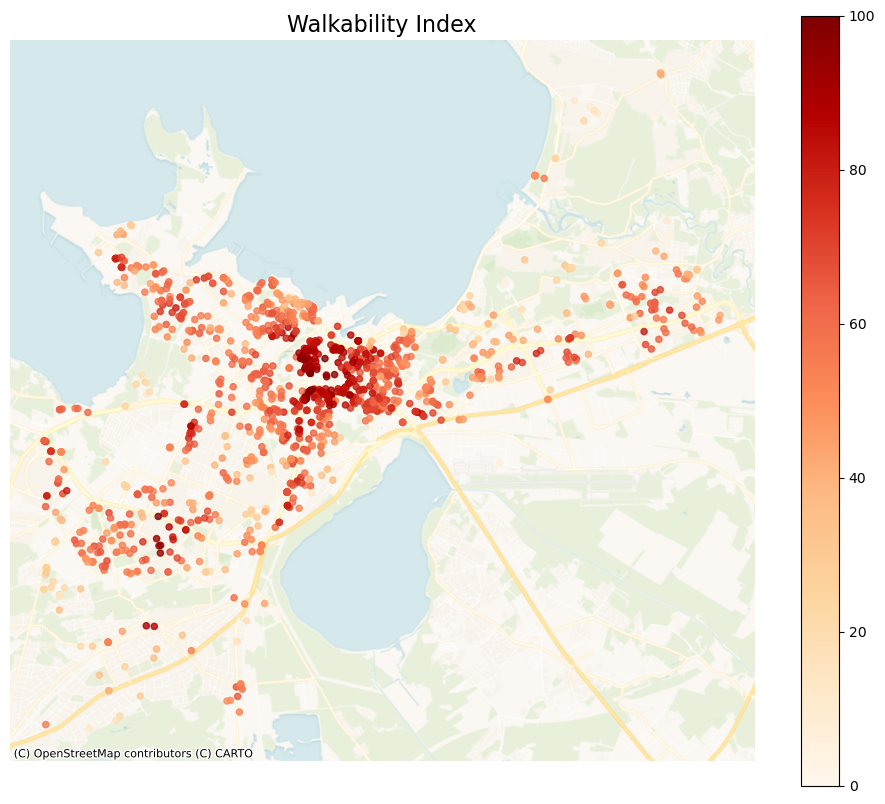

In [139]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_rent.plot(
    column="walkability_index",
    cmap="OrRd",
    legend=True,
    markersize=20,
    alpha=0.8,
    ax=ax
)
#gdf_place_web.boundary.plot(ax=ax, edgecolor="black", linewidth=2)


ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs=gdf_rent.crs)

ax.set_title("Walkability index", fontsize=16)
ax.axis('off')
plt.show()

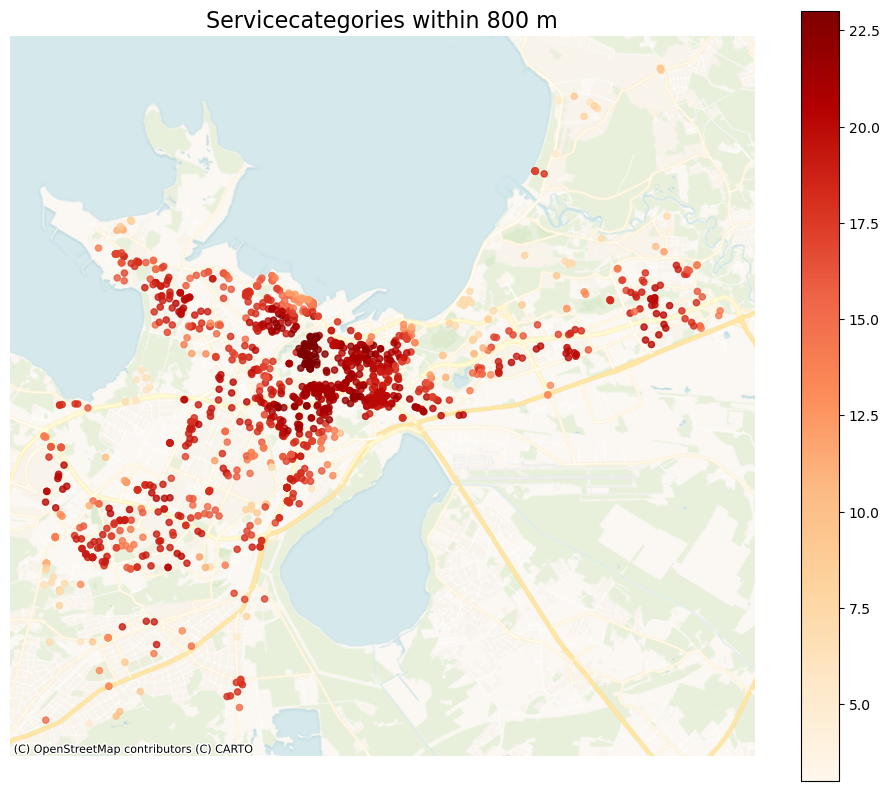

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_rent.plot(
    column="amenity_diversity_net",
    cmap="OrRd",
    legend=True,
    markersize=20,
    alpha=0.8,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs=gdf_rent.crs)

ax.set_title("Servicecategories within 800 m", fontsize=16)
ax.axis('off')
plt.show()


### Saving the engineered features

In [ ]:
gdf_rent.to_file("gdf_rent_engineered_tln.gpkg", layer="gdf_rent_engineered_tln", driver="GPKG")

In [ ]:
#gdf_rent_features = gpd.read_file("gdf_rent_engineered.gpkg", layer="gdf_rent_engineered")

In [ ]:
#gdf_rent_features.head()

# Model building (XGBoost with spacial CV (4000m folds when ≥ 10 listings), test set (Folds with < 10 listings), target encoding (2000m grid with average price of out of fold listings), categorised price (3 qunatiles)

### Imports

In [142]:
gdf_rent = gpd.read_file("gdf_rent_engineered_tln.gpkg", layer="gdf_rent_engineered_tln") # Import engineered rent data of Tallinn
asum_path = r"C:\Users\Dan\Documents\GitHub\KV-scraper-SAT\Analysis\Districts_data\asustusyksus.shp" # Importing .shp district file from Estonian Land and Spatial Development Board (Maa- ja ruumiamet) 
gdf_asum = gpd.read_file(asum_path)

### Finding which in district each point is

In [143]:
gdf_asum = gdf_asum.to_crs(gdf_rent.crs) # defining coordinate referece system
gdf_rent = gpd.sjoin(
    gdf_rent,
    gdf_asum[["ANIMI", "geometry"]],
    how="left",
    predicate="within") # spatial join

### Feature engineering again

In [144]:
# condition score value defining 5 - 0.5 score
condition_mapping = {
    'Uus': 5, 'San. remont tehtud': 4, 'Renoveeritud': 4,
    'Valmis': 3.5, 'Heas korras': 3, 'Keskmine': 2,
    'Vajab san. remonti': 1, 'Vajab renoveerimist': 0.5}

gdf_rent['condition_score'] = gdf_rent['condition'].map(condition_mapping).fillna(3) # mapping the values to the data

# derived features to improve the model
gdf_rent['age_of_building'] = 2025 - gdf_rent['build_year']
gdf_rent['floor_ratio'] = gdf_rent['floor'] / gdf_rent['total_floors'].replace(0, 1)
gdf_rent['room_density'] = gdf_rent['rooms'] / gdf_rent['area_sqm']
gdf_rent['condition_age_interaction'] = gdf_rent['condition_score'] * gdf_rent['age_of_building']
gdf_rent['floor_total_interaction'] = gdf_rent['floor_ratio'] * gdf_rent['total_floors']

# accessibility and density index for likely important features. Problem with this: transport only has buss station and trainstation
#gdf_rent['accessibility_index'] = (
    #0.4 * gdf_rent['dist_center'] +
    #0.3 * gdf_rent['dist_transport'] +
    #0.15 * gdf_rent['dist_food_grocery'] +
    #0.15 * gdf_rent['dist_parks_green'])

#gdf_rent['accessibility_index_min'] = gdf_rent['accessibility_index'] / 83.33 # accessibility index in regards to time 

#density_cols = [c for c in gdf_rent.columns if c.startswith("density_")]
#if density_cols:
    #gdf_rent['amenity_density_mean'] = gdf_rent[density_cols].mean(axis=1)
    #gdf_rent['amenity_density_sum'] = gdf_rent[density_cols].sum(axis=1)
#else:
    #gdf_rent['amenity_density_mean'] = 0.0
    #gdf_rent['amenity_density_sum'] = 0.0


### Categorise price per m2 into 3 classes to improve performace (3 price bins, quantile )

In [145]:
gdf_rent['price_category'] = pd.qcut(gdf_rent['price_per_m2'], q=3, labels=['budget', 'mid_range', 'premium']) # add lables to the categories

print("category distribution") # checking the distribution just in case
print(gdf_rent['price_category'].value_counts().sort_index())
print("ranges per category:") # checking the ranges generated
for cat in ['budget', 'mid_range', 'premium']:
    prices = gdf_rent[gdf_rent['price_category'] == cat]['price_per_m2']
    if len(prices) > 0:
        print(f"{cat}: {prices.min():.2f} - {prices.max():.2f} €/m2")

# mapping string labels to integers
label_mapping = {
    'budget': 0,
    'mid_range': 1,
    'premium': 2}
inv_label_mapping = {v: k for k, v in label_mapping.items()}
gdf_rent['price_category_int'] = gdf_rent['price_category'].map(label_mapping)

category distribution
price_category
budget       449
mid_range    447
premium      449
Name: count, dtype: int64
ranges per category:
budget: 2.68 - 12.50 €/m2
mid_range: 12.50 - 16.67 €/m2
premium: 16.68 - 47.14 €/m2


### Setting up grids for CV and target encoding

In [146]:
minx, miny, maxx, maxy = gdf_rent.total_bounds # finding bounding box for Tallinn's rental listings

# pulling out the longitude (x) and latitude (y) from each listing's location as separate numbers. Even though had latitude and longitude fields was not sure using those would work.
gdf_rent['geom_x'] = gdf_rent['geometry'].apply(lambda g: g.x)
gdf_rent['geom_y'] = gdf_rent['geometry'].apply(lambda g: g.y)

# defining feature grid for target encoding 
feature_grid_size = 2000 # setting the size of the grid
gdf_rent['grid_x'] = ((gdf_rent['geom_x'] - minx) // feature_grid_size).astype(int) # calculating grid coordinate x
gdf_rent['grid_y'] = ((gdf_rent['geom_y'] - miny) // feature_grid_size).astype(int) # calculating grid coordinate y
gdf_rent['grid_id'] = gdf_rent['grid_x'].astype(str) + "_" + gdf_rent['grid_y'].astype(str) # Assigning ID-s of which grid a point is within

# defining spatial CV blocks for crossvalidation
cv_block_size = 4000 # setting the size of the grid
gdf_rent['cv_block_x'] = ((gdf_rent['geom_x'] - minx) // cv_block_size).astype(int) # calculating grid coordinate x
gdf_rent['cv_block_y'] = ((gdf_rent['geom_y'] - miny) // cv_block_size).astype(int) # calculating grid coordinate y
gdf_rent['cv_block_id'] = gdf_rent['cv_block_x'].astype(str) + "_" + gdf_rent['cv_block_y'].astype(str) # Assigning ID-s of which grid a point is within

### Splitting data into CV dataset and Test dataset (test dataset will be all CV folds with less than 10 listings in them)

In [147]:
grid_counts = gdf_rent['grid_id'].value_counts() # counts how many rental listings are within each grid
valid_grids = grid_counts[grid_counts >= 10].index # counts valid grids with more than 10 listings
invalid_grids = grid_counts[grid_counts < 10].index # counts invalid grids with less than 10 listings

# output to toubleshoot/look at the data
print(f"Dataset split")
print(f"Feature grid size: {feature_grid_size}m") 
print(f"CV block size: {cv_block_size}m")
print(f"Total feature grid cells: {len(grid_counts)}")
print(f"Cells with ≥10 listings (CV dataset): {len(valid_grids)}")
print(f"Cells with <10 listings (Test dataset): {len(invalid_grids)}")

# spliting data based on if it is valid fold or no.
gdf_cv = gdf_rent[gdf_rent['grid_id'].isin(valid_grids)].copy()
gdf_test = gdf_rent[gdf_rent['grid_id'].isin(invalid_grids)].copy()

print(f"\nCV dataset size: {len(gdf_cv)}")
print(f"Test dataset size: {len(gdf_test)}")

# output to toubleshoot/look at the data
cv_block_counts = gdf_cv['cv_block_id'].value_counts()
print(f"\nCV blocks: {len(cv_block_counts)}")
print(f"Min listings per CV block: {cv_block_counts.min()}")
print(f"Max listings per CV block: {cv_block_counts.max()}")
print(f"Mean listings per CV block: {cv_block_counts.mean():.1f}")


Dataset split
Feature grid size: 2000m
CV block size: 4000m
Total feature grid cells: 30
Cells with ≥10 listings (CV dataset): 20
Cells with <10 listings (Test dataset): 10

CV dataset size: 1289
Test dataset size: 56

CV blocks: 9
Min listings per CV block: 12
Max listings per CV block: 518
Mean listings per CV block: 143.2


### Data preparation

In [148]:
# excluding these columns because they are either useless or would leak data or will be encoded later.
exclude_cols = [
    'id', 'url', 'geometry', 'price', 'price_per_m2', 'condition', 'nearest_node',
    'ANIMI', 'price_category', 'geom_x', 'geom_y', 
    'grid_x', 'grid_y', 'grid_id', 'cv_block_x', 'cv_block_y', 'cv_block_id']

# excluding score columns because they were created to create the walkability index and would basically mean the same thing as distance for the model (colinearity)
score_cols = [c for c in gdf_rent.columns if c.startswith("score_")]
exclude_cols.extend(score_cols) 
# creating a list of feature columns that are numeric and are not in excluded columns
feature_cols = [c for c in gdf_cv.columns
                if c not in exclude_cols
                and pd.api.types.is_numeric_dtype(gdf_cv[c])]

# creating CV dataset
X_cv = gdf_cv[feature_cols + ['ANIMI', 'grid_id']].copy() # Adding features. some features added back because they will be encoded later and will not be used as numeric features
y_cv_int = gdf_cv['price_category_int'].copy() # integer for classification
y_cv_str = gdf_cv['price_category'].copy() # string for reporing
y_cv_numeric = gdf_cv['price_per_m2'].copy() # numeric to check true errors
groups_cv = gdf_cv['cv_block_id'].copy() # each listing to its column

# Creating Test dataset
X_test = gdf_test[feature_cols + ['ANIMI', 'grid_id']].copy() # Adding features. some features added back because they will be encoded later and will not be used as numeric features
y_test_int = gdf_test['price_category_int'].copy() # integer for classification
y_test_str = gdf_test['price_category'].copy() # string for reporing
y_test_numeric = gdf_test['price_per_m2'].copy() # each listing to its column


### Defining functions for encoding

In [149]:
# Function for smooth target encoding for a grid or a district
def smooth_target_encoding(df, col, target, alpha=10): 
    global_mean = df[target].mean() # overall average of the target across the entire dataset
    stats = df.groupby(col)[target].agg(['mean', 'count']) # calculates the mean target value and number of samples in that category
    stats['smooth'] = (stats['mean'] * stats['count'] + global_mean * alpha) / (stats['count'] + alpha) # smoothing formula for overfitting
    return df[col].map(stats['smooth']).fillna(global_mean), stats # returns encoded column full stats table.

def apply_encoding_with_stats(df, col, stats, global_mean): # function for validation or test encoding to avoid data leakage
    return df[col].map(stats['smooth']).fillna(global_mean) # for each row of the new dataframe uses smoothed value. if no smooth value possible uses global_mean


### Spacial 5 fold CV

In [150]:
# creating 5 fold CV with groups. helps with dataleakage, listings from the same spatial block never appear in both train and val sets.
gkf = GroupKFold(n_splits=5)

# dictionary for storing CV evaluation metrics. # used for final reports
cv_results = {
    'fold': [],
    'accuracy': [],
    'kappa': [],
    'rmse': [],
    'mae': [],
    'mape': [],
    'r2': [],
    'train_size': [],
    'val_size': []}

# lists for collecting peredictons
all_y_true_str_cv = []
all_y_pred_str_cv = []
all_y_true_numeric_cv = []
all_y_pred_numeric_cv = []

# encoding stats from each fold for later averages. for each fold encoding tables, mean price_per_m2, etc are stored for averaging these to use on test dataset.
all_animi_stats = []
all_onimi_stats = []
all_grid_stats = []
all_global_means = []
all_category_medians = []

In [151]:
fold_assignment_map = {}  # map indices to fold numbers. for visualization

In [152]:
# for loop for each fold
for fold_idx, (train_idx, val_idx) in enumerate(gkf.split(X_cv, y_cv_int, groups=groups_cv), 1): # for each fold runs gkf.split to see what indexes to use for train and what for validation
    # for each fold decides which rows belong in which fold. Rows with the same group ID will always go together. 
    # fold assignment is based on spatial blocks, not random rows. prevents spacial leakage
    # Starts numbering at 1 for better printing
    print(f"\nFold {fold_idx}/5") # prints what fold is currently being processed
    # storing which fold these validation indices belong to for visualization
    for idx in val_idx:
        fold_assignment_map[idx] = fold_idx
    
    # splitting input features into training and validation subsets.
    X_train_fold = X_cv.iloc[train_idx].copy()
    X_val_fold = X_cv.iloc[val_idx].copy()

    # spliting target labels. both integer and string labels
    y_train_int = y_cv_int.iloc[train_idx].copy()
    y_val_int = y_cv_int.iloc[val_idx].copy()
    y_train_str = y_cv_str.iloc[train_idx].copy()
    y_val_str = y_cv_str.iloc[val_idx].copy()

    #spliting numeric target (price_per_m2)
    y_train_numeric_fold = y_cv_numeric.iloc[train_idx].copy()
    y_val_numeric_fold = y_cv_numeric.iloc[val_idx].copy()
    # printing fold sizes to know the balaces of the folds
    print(f"train size: {len(train_idx)} | val size: {len(val_idx)}")
    
    # target encoding within fold
    # computing global mean price. fallback
    global_mean = y_train_numeric_fold.mean()
    all_global_means.append(global_mean)

    # temporary df for target encoding 
    tmp_train_enc = X_train_fold[['ANIMI', 'grid_id']].copy()
    tmp_train_enc = tmp_train_enc.assign(price_per_m2=y_train_numeric_fold.values)
    
    # ANIMI encoding. target encoding for each district in tallinn
    # for training set smoothed encoding with defined function and gives encoded values + stats table
    # for validation set uses training encoding stats
    X_train_fold['ANIMI_enc'], animi_stats = smooth_target_encoding(
        tmp_train_enc, 'ANIMI', 'price_per_m2', alpha=10
    )
    X_val_fold['ANIMI_enc'] = apply_encoding_with_stats(
        X_val_fold, 'ANIMI', animi_stats, global_mean
    )
    all_animi_stats.append(animi_stats)
    
    # ONIMI encoding
    #X_train_fold['ONIMI_enc'], onimi_stats = smooth_target_encoding(
    #    tmp_train_enc, 'ONIMI', 'price_per_m2', alpha=10
    #)
    #X_val_fold['ONIMI_enc'] = apply_encoding_with_stats(
    #    X_val_fold, 'ONIMI', onimi_stats, global_mean
    #)
    #all_onimi_stats.append(onimi_stats)
    
    # Grid mean encoding
    # for training set smoothed encoding with defined function and gives encoded values + stats table
    # for validation set uses training encoding stats
    # alpha value is higher because grids can have less values within them than districts
    X_train_fold['grid_mean_price'], grid_stats = smooth_target_encoding(
        tmp_train_enc, 'grid_id', 'price_per_m2', alpha=20
    )
    X_val_fold['grid_mean_price'] = apply_encoding_with_stats(
        X_val_fold, 'grid_id', grid_stats, global_mean
    )
    all_grid_stats.append(grid_stats)
    
    # store category medians for this fold. used to convert class predictions to numeric predictions 
    label_list = ['budget', 'mid_range', 'premium']
    category_medians = y_train_numeric_fold.groupby(y_train_str).median()
    category_medians = category_medians.reindex(label_list).fillna(global_mean)
    all_category_medians.append(category_medians)
    
    # drop categorical columns to clean up feature set so only encoded versions remain
    X_train_fold = X_train_fold.drop(columns=['ANIMI', 'grid_id'])
    X_val_fold = X_val_fold.drop(columns=['ANIMI', 'grid_id'])
    
    # fill with training medians NaN values just incase.   
    train_medians = X_train_fold.median(numeric_only=True)
    X_train_fold = X_train_fold.fillna(train_medians)
    X_val_fold = X_val_fold.fillna(train_medians)
    X_val_fold = X_val_fold[X_train_fold.columns] # Aligning columns
    
    # MODEL XGBoost regularized
    model = XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.6,
        min_child_weight=8,
        gamma=1.0,
        reg_alpha=2.0,
        reg_lambda=3.0,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    
    model.fit(X_train_fold, y_train_int, verbose=False) # train model on train data
    
    # predictions
    y_pred_int = model.predict(X_val_fold) # integer label
    y_pred_str = pd.Series(y_pred_int).map(inv_label_mapping).astype(object) # integer label to string label
    
    # metrics 
    acc = accuracy_score(y_val_str, y_pred_str)
    kappa = cohen_kappa_score(y_val_str, y_pred_str)
    
    y_pred_numeric_fold = pd.Series(y_pred_str).map(category_medians).values # predicted categories to numeric prices

    # regression metrics 
    rmse = np.sqrt(mean_squared_error(y_val_numeric_fold, y_pred_numeric_fold))
    mae = mean_absolute_error(y_val_numeric_fold, y_pred_numeric_fold)
    mape = mean_absolute_percentage_error(y_val_numeric_fold, y_pred_numeric_fold)
    r2 = r2_score(y_val_numeric_fold, y_pred_numeric_fold)

    # metrics and predictions stroed
    cv_results['fold'].append(fold_idx)
    cv_results['accuracy'].append(acc)
    cv_results['kappa'].append(kappa)
    cv_results['rmse'].append(rmse)
    cv_results['mae'].append(mae)
    cv_results['mape'].append(mape)
    cv_results['r2'].append(r2)
    cv_results['train_size'].append(len(train_idx))
    cv_results['val_size'].append(len(val_idx))
    
    all_y_true_str_cv.extend(y_val_str.tolist())
    all_y_pred_str_cv.extend(y_pred_str.tolist())
    all_y_true_numeric_cv.extend(y_val_numeric_fold.tolist())
    all_y_pred_numeric_cv.extend(y_pred_numeric_fold.tolist())

    # printing results for each fold
    print(f"accuracy: {acc:.4f} | kappa: {kappa:.4f}")
    print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape*100:.2f}% | R2: {r2:.4f}")


Fold 1/5
train size: 771 | val size: 518


C:\Users\Dan\AppData\Local\Temp\ipykernel_13292\542625930.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_medians = y_train_numeric_fold.groupby(y_train_str).median()


accuracy: 0.5946 | kappa: 0.3923
RMSE: 4.01 | MAE: 3.03 | MAPE: 20.78% | R2: 0.2170

Fold 2/5
train size: 1074 | val size: 215


C:\Users\Dan\AppData\Local\Temp\ipykernel_13292\542625930.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_medians = y_train_numeric_fold.groupby(y_train_str).median()


accuracy: 0.5070 | kappa: 0.2788
RMSE: 5.34 | MAE: 3.95 | MAPE: 21.97% | R2: 0.0232

Fold 3/5
train size: 1111 | val size: 178


C:\Users\Dan\AppData\Local\Temp\ipykernel_13292\542625930.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_medians = y_train_numeric_fold.groupby(y_train_str).median()


accuracy: 0.6966 | kappa: 0.5462
RMSE: 3.79 | MAE: 2.54 | MAPE: 16.60% | R2: 0.5055

Fold 4/5
train size: 1082 | val size: 207


C:\Users\Dan\AppData\Local\Temp\ipykernel_13292\542625930.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_medians = y_train_numeric_fold.groupby(y_train_str).median()


accuracy: 0.6232 | kappa: 0.4281
RMSE: 3.42 | MAE: 2.63 | MAPE: 18.94% | R2: 0.4296

Fold 5/5
train size: 1118 | val size: 171


C:\Users\Dan\AppData\Local\Temp\ipykernel_13292\542625930.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_medians = y_train_numeric_fold.groupby(y_train_str).median()


accuracy: 0.7310 | kappa: 0.5885
RMSE: 4.14 | MAE: 2.66 | MAPE: 17.77% | R2: 0.5001


In [153]:
# Save fold assignments for later visualization
gdf_cv['fold_assignment'] = gdf_cv.index.map(fold_assignment_map)

### CV results overview

In [154]:
results_df = pd.DataFrame(cv_results)
print("spatial CV sumary for CV data")
print(results_df.to_string(index=False))
print("mean metrics:")
print(f"Accuracy:  {results_df['accuracy'].mean():.4f} (±{results_df['accuracy'].std():.4f})")
print(f"Kappa:     {results_df['kappa'].mean():.4f} (±{results_df['kappa'].std():.4f})")
print(f"RMSE:      {results_df['rmse'].mean():.2f} (±{results_df['rmse'].std():.2f})")
print(f"MAE:       {results_df['mae'].mean():.2f} (±{results_df['mae'].std():.2f})")
print(f"MAPE:      {results_df['mape'].mean()*100:.2f}% (±{results_df['mape'].std()*100:.2f}%)")
print(f"R²:        {results_df['r2'].mean():.4f} (±{results_df['r2'].std():.4f})")

spatial CV sumary for CV data
 fold  accuracy    kappa     rmse      mae     mape       r2  train_size  val_size
    1  0.594595 0.392270 4.006434 3.031305 0.207838 0.216995         771       518
    2  0.506977 0.278843 5.336821 3.947560 0.219654 0.023174        1074       215
    3  0.696629 0.546176 3.787085 2.542216 0.166020 0.505544        1111       178
    4  0.623188 0.428076 3.419386 2.625629 0.189397 0.429566        1082       207
    5  0.730994 0.588512 4.144331 2.657595 0.177727 0.500108        1118       171
mean metrics:
Accuracy:  0.6305 (±0.0881)
Kappa:     0.4468 (±0.1240)
RMSE:      4.14 (±0.72)
MAE:       2.96 (±0.58)
MAPE:      19.21% (±2.18%)
R²:        0.3351 (±0.2100)


### final model on entire dataset

In [155]:
# copy data to make sure original data stays
X_cv_full = X_cv.copy() 
y_cv_full_int = y_cv_int.copy()
y_cv_full_str = y_cv_str.copy()
y_cv_full_numeric = y_cv_numeric.copy()

# average of 5 fold means to encode full dataset
global_mean_final = np.mean(all_global_means)

# merging encoding stats across all folds
def combine_stats(all_stats_list, global_mean):
    combined = pd.concat([s['smooth'] for s in all_stats_list], axis=1).mean(axis=1)
    return combined
# final encoding to full dataset
animi_enc_final = X_cv_full['ANIMI'].map(combine_stats(all_animi_stats, global_mean_final)).fillna(global_mean_final)
#onimi_enc_final = X_cv_full['ONIMI'].map(combine_stats(all_onimi_stats, global_mean_final)).fillna(global_mean_final)
grid_enc_final = X_cv_full['grid_id'].map(combine_stats(all_grid_stats, global_mean_final)).fillna(global_mean_final)
# encoded features and drop categorical columns
X_cv_full['ANIMI_enc'] = animi_enc_final
#X_cv_full['ONIMI_enc'] = onimi_enc_final
X_cv_full['grid_mean_price'] = grid_enc_final
X_cv_full = X_cv_full.drop(columns=['ANIMI', 'grid_id'])

# missing numeric values filled with median just incase
cv_medians = X_cv_full.median(numeric_only=True)
X_cv_full = X_cv_full.fillna(cv_medians)

#final model. hyperparameters are the same
final_model = XGBClassifier(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.6,
    min_child_weight=8,
    gamma=1.0,
    reg_alpha=2.0,
    reg_lambda=3.0,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

final_model.fit(X_cv_full, y_cv_full_int, verbose=False)
print("done")

done


### Predicting onto test set (CV grids with <10 listings)

In [156]:
X_test_pred = X_test.copy() # copy of the test features

# Apply averaged encoding if doesnt exist uses global mean
X_test_pred['ANIMI_enc'] = X_test_pred['ANIMI'].map(
    combine_stats(all_animi_stats, global_mean_final)
).fillna(global_mean_final)

#X_test_pred['ONIMI_enc'] = X_test_pred['ONIMI'].map(
    #combine_stats(all_onimi_stats, global_mean_final)
#).fillna(global_mean_final)

# Apply averaged encoding if doesnt exist uses global mean
X_test_pred['grid_mean_price'] = X_test_pred['grid_id'].map(
    combine_stats(all_grid_stats, global_mean_final)
).fillna(global_mean_final)

X_test_pred = X_test_pred.drop(columns=['ANIMI', 'grid_id']) # Drop categorical columns
# missing values and align columns
X_test_pred = X_test_pred.fillna(cv_medians) # 
X_test_pred = X_test_pred[X_cv_full.columns]

# making predictions onto the test dataset
y_test_pred_int = final_model.predict(X_test_pred)
y_test_pred_str = pd.Series(y_test_pred_int).map(inv_label_mapping).astype(object)

# Use averaged category medians for numeric predictions
# predicted class mapped to its average median price across folds. similar to predicting actual price per m2. used for MAPE etc. getting an overview of the model performace
avg_category_medians = pd.concat(all_category_medians, axis=1).mean(axis=1)
y_test_pred_numeric = pd.Series(y_test_pred_str).map(avg_category_medians).values

# metrics
test_acc = accuracy_score(y_test_str, y_test_pred_str) # class prediction metrics
test_kappa = cohen_kappa_score(y_test_str, y_test_pred_str) # class prediction metrics
test_rmse = np.sqrt(mean_squared_error(y_test_numeric, y_test_pred_numeric)) # numeric prediction metric
test_mae = mean_absolute_error(y_test_numeric, y_test_pred_numeric) # numeric prediction metric
test_mape = mean_absolute_percentage_error(y_test_numeric, y_test_pred_numeric) # numeric prediction metric
test_r2 = r2_score(y_test_numeric, y_test_pred_numeric) # numeric prediction metric

# printing metrics
print(f"\nTest Set Size: {len(y_test_str)}")
print(f"Accuracy:  {test_acc:.4f}") # class prediction metrics
print(f"Kappa:     {test_kappa:.4f}") # class prediction metrics
print(f"RMSE:      {test_rmse:.2f}") # numeric prediction metric
print(f"MAE:       {test_mae:.2f}") # numeric prediction metric
print(f"MAPE:      {test_mape*100:.2f}%") # numeric prediction metric
print(f"R²:        {test_r2:.4f}") # numeric prediction metric


label_list = ['budget', 'mid_range', 'premium']
print(classification_report(y_test_str, y_test_pred_str, labels=label_list, zero_division=0)) # precision, recall, f1-score for each class

print("\nTest set confusion matrix:")
cm_test = confusion_matrix(y_test_str, y_test_pred_str, labels=label_list)
cm_test_df = pd.DataFrame(cm_test, index=label_list, columns=label_list)
print(cm_test_df)


Test Set Size: 56
Accuracy:  0.7143
Kappa:     0.5518
RMSE:      4.01
MAE:       2.85
MAPE:      21.78%
R²:        0.2766
              precision    recall  f1-score   support

      budget       0.69      0.96      0.80        23
   mid_range       0.86      0.38      0.52        16
     premium       0.71      0.71      0.71        17

    accuracy                           0.71        56
   macro avg       0.75      0.68      0.68        56
weighted avg       0.74      0.71      0.69        56


Test set confusion matrix:
           budget  mid_range  premium
budget         22          1        0
mid_range       5          6        5
premium         5          0       12


### Overall performace of crossvalidation

In [157]:
label_list = ['budget', 'mid_range', 'premium']
print(classification_report(all_y_true_str_cv, all_y_pred_str_cv, labels=label_list, zero_division=0))

print("\nCV Confusion Matrix:")
cm_cv = confusion_matrix(all_y_true_str_cv, all_y_pred_str_cv, labels=label_list)
cm_cv_df = pd.DataFrame(cm_cv, index=label_list, columns=label_list)
print(cm_cv_df)

              precision    recall  f1-score   support

      budget       0.61      0.74      0.67       426
   mid_range       0.51      0.48      0.50       431
     premium       0.75      0.63      0.69       432

    accuracy                           0.62      1289
   macro avg       0.62      0.62      0.62      1289
weighted avg       0.62      0.62      0.62      1289


CV Confusion Matrix:
           budget  mid_range  premium
budget        315         87       24
mid_range     156        207       68
premium        49        110      273


# Visualizations

### Fold visualisations

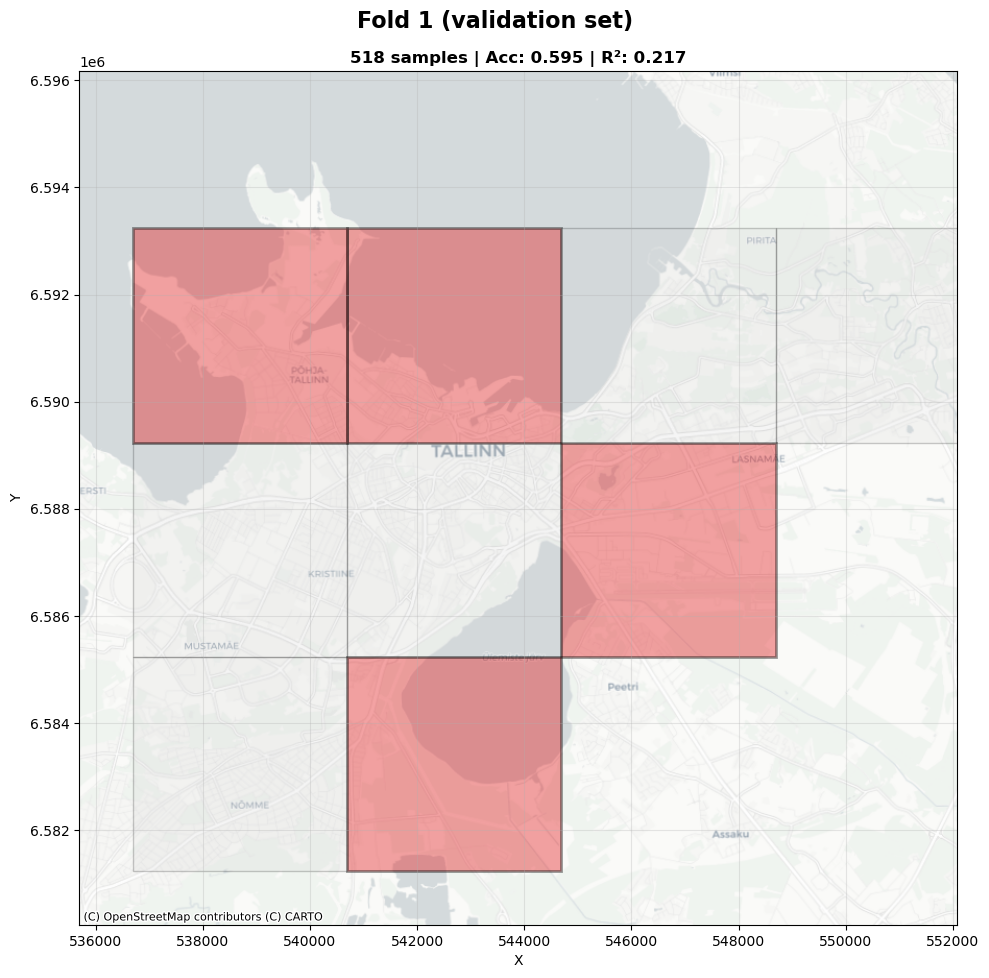

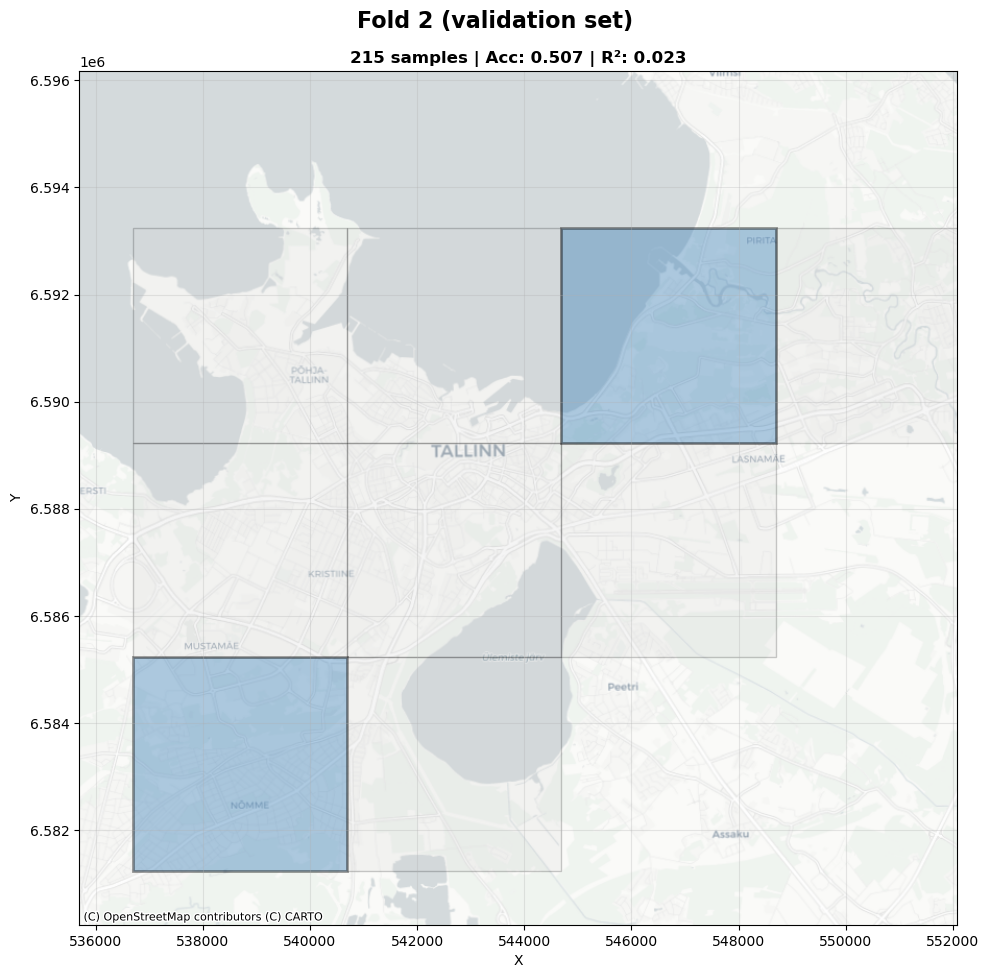

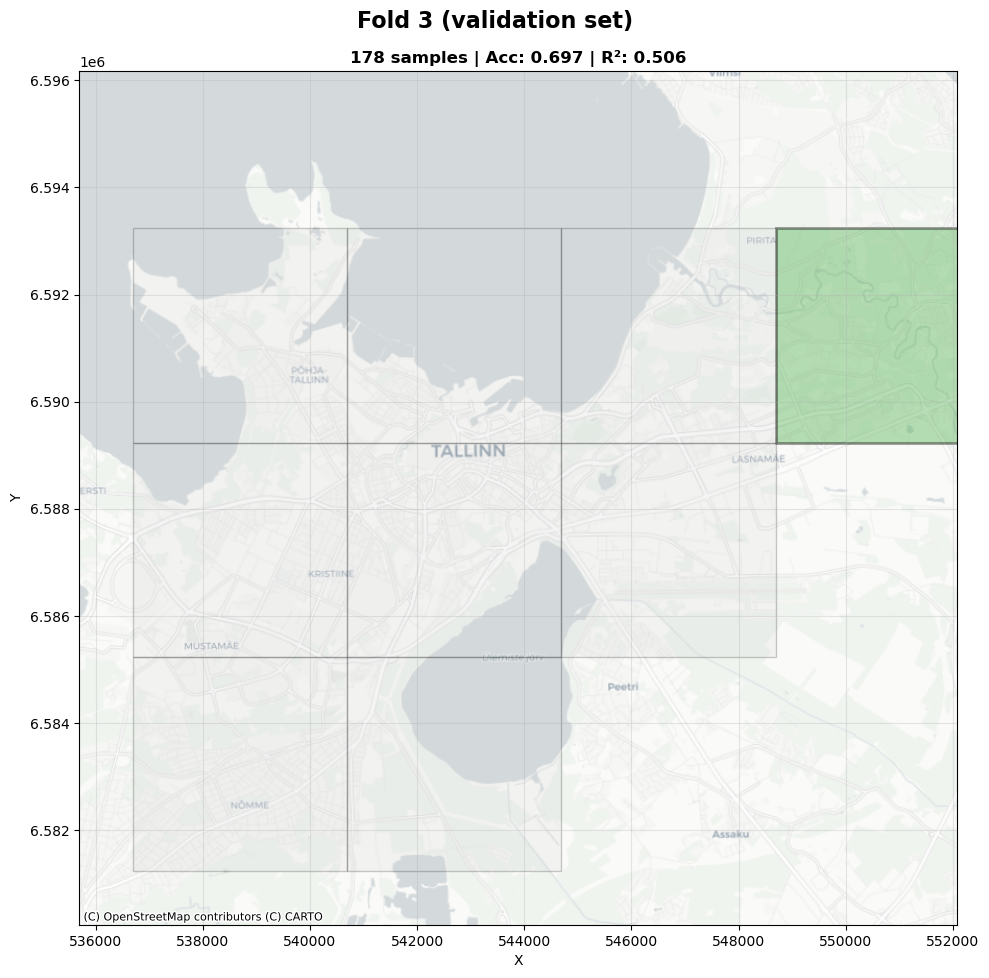

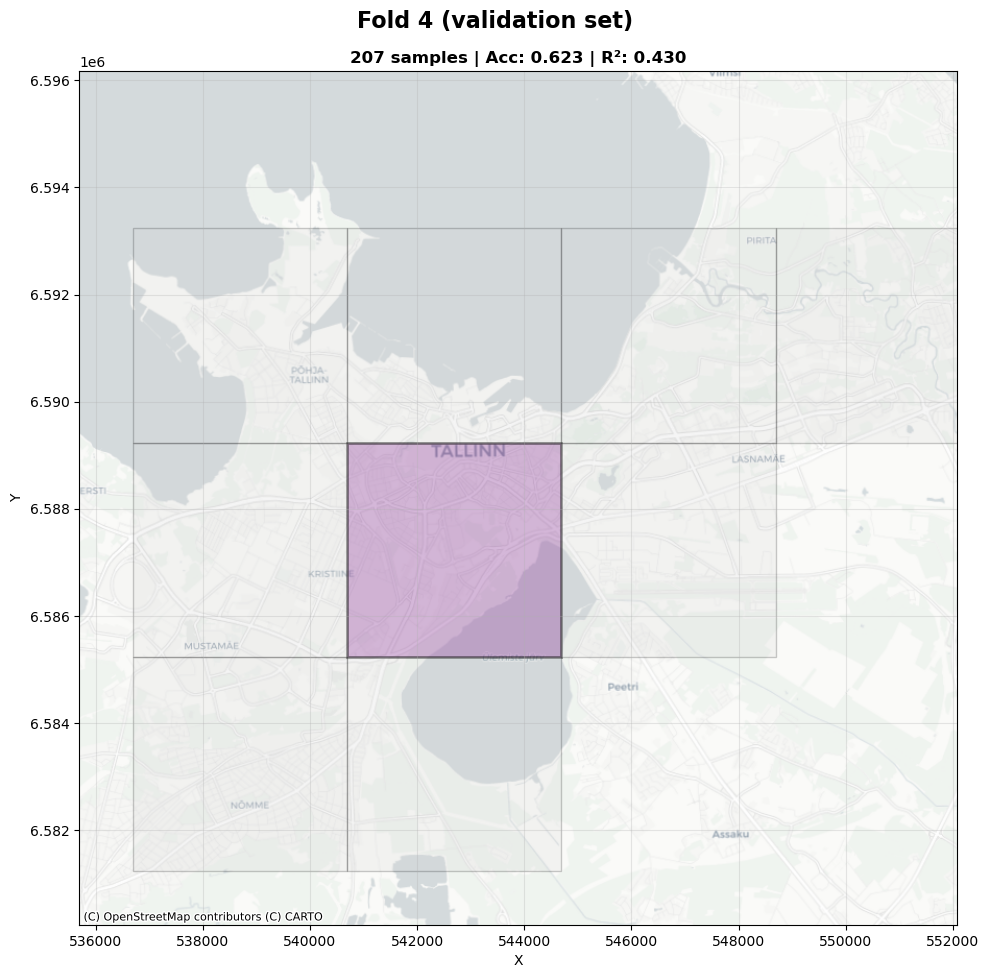

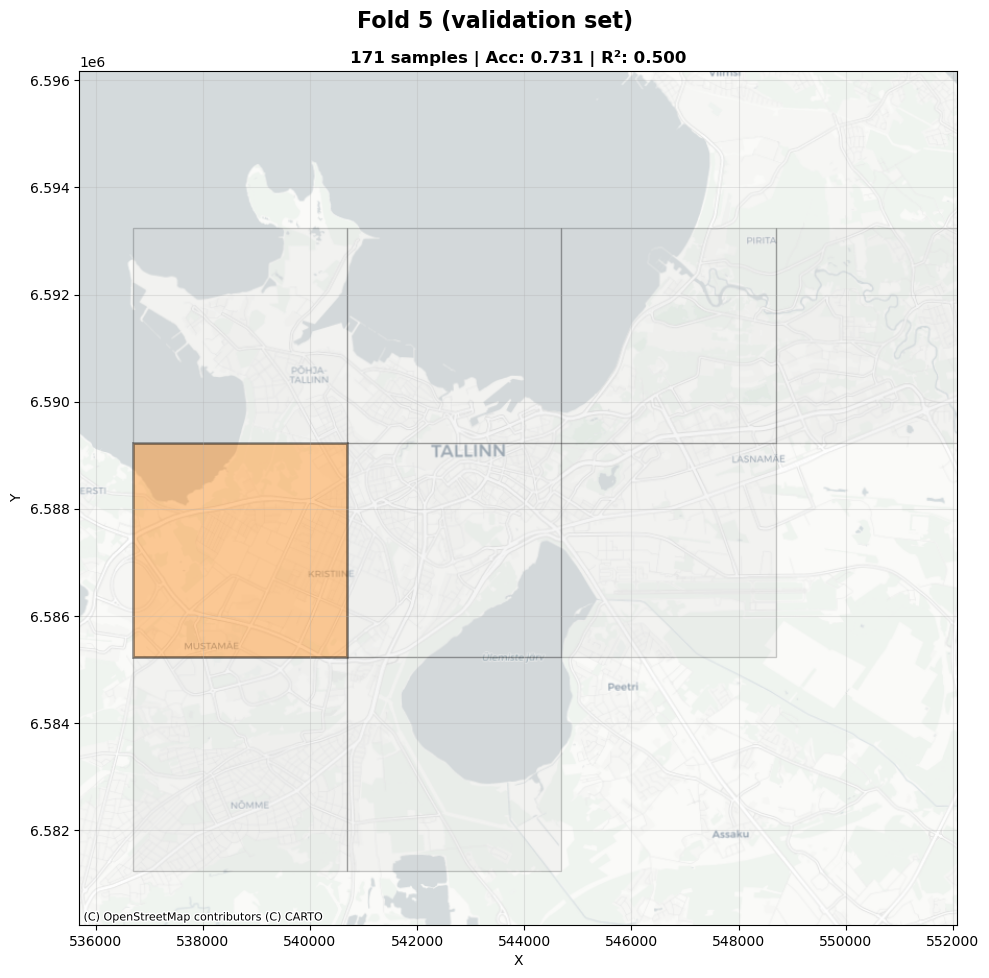

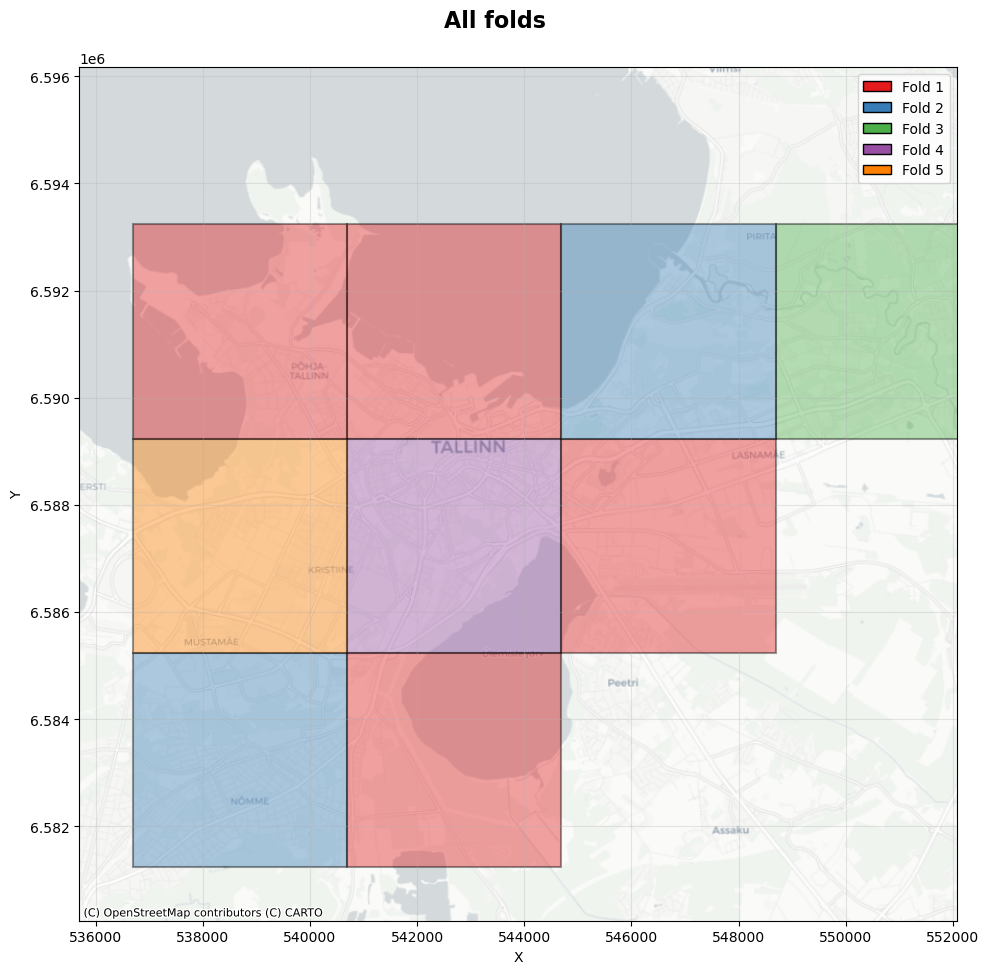

In [158]:
# mapping each cv_block_id to its fold using the saved assignments
block_to_fold = {}
for idx, row in gdf_cv.iterrows():
    block_id = row['cv_block_id']
    fold = row['fold_assignment']
    if pd.notna(fold):
        block_to_fold[block_id] = int(fold)

#unique blocks with their coordinates
unique_blocks = gdf_cv[['cv_block_id', 'cv_block_x', 'cv_block_y']].drop_duplicates()

# colors for each fold
fold_colors = {1: '#e41a1c', 2: '#377eb8', 3: '#4daf4a', 4: '#984ea3', 5: '#ff7f00'}

# plotting each fold 1-5
for fold in [1, 2, 3, 4, 5]:
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.suptitle(f'Fold {fold} (validation set)', fontsize=16, fontweight='bold')
    
    # drawing all grid squares
    for _, row in unique_blocks.iterrows():
        block_id = row['cv_block_id']
        block_fold = block_to_fold.get(block_id, None)
        
        x_start = minx + row['cv_block_x'] * cv_block_size
        y_start = miny + row['cv_block_y'] * cv_block_size
        
        if block_fold == fold:
            color = fold_colors[fold]
            alpha = 0.4
            linewidth = 2
        else:
            color = 'lightgray'
            alpha = 0.2
            linewidth = 1
        
        rect = mpatches.Rectangle((x_start, y_start), cv_block_size, cv_block_size,
                                   linewidth=linewidth, edgecolor='black', facecolor=color, alpha=alpha)
        ax.add_patch(rect)
    
    #limits to use basemap
    ax.set_xlim(minx - 1000, maxx + 1000)
    ax.set_ylim(miny - 1000, maxy + 1000)
    
    # CartoDB basemap in ESPG_3301
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_rent.crs.to_string())
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    #performance metrics to title
    acc = cv_results['accuracy'][fold-1]
    r2 = cv_results['r2'][fold-1]
    val_size = cv_results['val_size'][fold-1]
    ax.set_title(f'{val_size} samples | Acc: {acc:.3f} | R²: {r2:.3f}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# all folds combined
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('All folds', fontsize=16, fontweight='bold')

for _, row in unique_blocks.iterrows():
    block_id = row['cv_block_id']
    block_fold = block_to_fold.get(block_id, None)
    
    x_start = minx + row['cv_block_x'] * cv_block_size
    y_start = miny + row['cv_block_y'] * cv_block_size
    
    if block_fold is not None:
        color = fold_colors[block_fold]
        alpha = 0.4
    else:
        color = 'lightgray'
        alpha = 0.2
    
    rect = mpatches.Rectangle((x_start, y_start), cv_block_size, cv_block_size,
                               linewidth=1.5, edgecolor='black', facecolor=color, alpha=alpha)
    ax.add_patch(rect)

#limits to use basemap
ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

# adding basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_rent.crs.to_string())

ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('X')
ax.set_ylabel('Y')

# legend
legend_elements = [mpatches.Patch(facecolor=fold_colors[f], edgecolor='black', label=f'Fold {f}') for f in range(1, 6)]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

### Price per m2 interpolation map (IDW)

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial import cKDTree
import warnings
warnings.filterwarnings('ignore')

def idw_interpolation(coords, values, xi_grid, yi_grid, power=2, smoothing=0):
    # Flatten grid coordinates
    grid_points = np.column_stack([xi_grid.flatten(), yi_grid.flatten()])
    
    # Build KD-tree for efficient nearest neighbor search
    tree = cKDTree(coords)
    
    # Calculate distances from each grid point to all data points
    distances, indices = tree.query(grid_points, k=len(coords))
    
    # Avoid division by zero by adding small smoothing factor
    distances = distances + smoothing
    
    # Calculate weights (inverse distance with power)
    weights = 1.0 / (distances ** power)
    
    # Normalize weights
    weights_sum = np.sum(weights, axis=1)
    weights_normalized = weights / weights_sum[:, np.newaxis]
    
    # Calculate interpolated values
    zi = np.sum(weights_normalized * values[indices], axis=1)
    
    # Reshape to grid shape
    return zi.reshape(xi_grid.shape)

# Load the data
gdf_rent = gpd.read_file("gdf_rent_engineered_tln.gpkg", layer="gdf_rent_engineered_tln")
asum_path = r"C:\Users\Dan\Documents\GitHub\KV-scraper-SAT\Analysis\Districts_data\asustusyksus.shp"
gdf_asum = gpd.read_file(asum_path)

# Filter for Tallinn boundary
tallinn_boundary = gdf_asum[gdf_asum['ONIMI'] == 'Tallinn'].copy()

# Ensure same CRS
if gdf_rent.crs != tallinn_boundary.crs:
    gdf_rent = gdf_rent.to_crs(tallinn_boundary.crs)

# Clip rent data to Tallinn boundary
gdf_rent_tallinn = gpd.clip(gdf_rent, tallinn_boundary)

# Extract coordinates and price values
coords = np.array([(point.x, point.y) for point in gdf_rent_tallinn.geometry])
values = gdf_rent_tallinn['price_per_m2'].values

# Remove any NaN values
mask = ~np.isnan(values)
coords = coords[mask]
values = values[mask]

print(f"Number of data points: {len(coords)}")
print(f"Price range: €{values.min():.2f} - €{values.max():.2f} per m²")
print(f"Mean price: €{values.mean():.2f} per m²")
print(f"Median price: €{np.median(values):.2f} per m²")

# Get bounds from the actual data points
minx, miny = coords.min(axis=0)
maxx, maxy = coords.max(axis=0)

# Extend bounds by 1000m on each side
minx -= 1000
maxx += 1000
miny -= 1000
maxy += 1000

# Create grid for interpolation
grid_resolution = 200  # Adjust for finer/coarser resolution
xi = np.linspace(minx, maxx, grid_resolution)
yi = np.linspace(miny, maxy, grid_resolution)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Perform IDW interpolation with different power parameters
print("\nPerforming IDW interpolation...")
zi_idw_p2 = idw_interpolation(coords, values, xi_grid, yi_grid, power=2, smoothing=0.0)
zi_idw_p3 = idw_interpolation(coords, values, xi_grid, yi_grid, power=3, smoothing=0.0)

# Mask points outside Tallinn boundary
print("Masking to Tallinn boundary...")
grid_points = [Point(x, y) for x, y in zip(xi_grid.flatten(), yi_grid.flatten())]
gdf_grid = gpd.GeoDataFrame(geometry=grid_points, crs=tallinn_boundary.crs)
within_tallinn = gdf_grid.within(tallinn_boundary.union_all())
mask_grid = within_tallinn.values.reshape(xi_grid.shape)

# Apply mask
zi_idw_p2_masked = np.where(mask_grid, zi_idw_p2, np.nan)
zi_idw_p3_masked = np.where(mask_grid, zi_idw_p3, np.nan)

# Calculate quantiles (tertiles) from the original data values
quantiles = np.quantile(values, [0.333, 0.667])
print(f"\nPrice categories (tertiles):")
print(f"  Low: €{values.min():.2f} - €{quantiles[0]:.2f}")
print(f"  Medium: €{quantiles[0]:.2f} - €{quantiles[1]:.2f}")
print(f"  High: €{quantiles[1]:.2f} - €{values.max():.2f}")

# Create categorical versions
def categorize_prices(zi, quantiles):
    """Categorize interpolated values into low/medium/high based on quantiles"""
    zi_cat = np.full_like(zi, np.nan)
    zi_cat = np.where(zi <= quantiles[0], 1, zi_cat)  # Low
    zi_cat = np.where((zi > quantiles[0]) & (zi <= quantiles[1]), 2, zi_cat)  # Medium
    zi_cat = np.where(zi > quantiles[1], 3, zi_cat)  # High
    return zi_cat

zi_idw_p2_cat = categorize_prices(zi_idw_p2_masked, quantiles)
zi_idw_p3_cat = categorize_prices(zi_idw_p3_masked, quantiles)

# Define colors for categories
from matplotlib.colors import ListedColormap
category_colors = ['#4daf4a', '#ffff33', '#e41a1c']  # Green (low), Yellow (medium), Red (high)
cmap_categorical = ListedColormap(category_colors)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Plot 1: IDW with power=2 (continuous)
im1 = axes[0, 0].contourf(xi_grid, yi_grid, zi_idw_p2_masked, levels=15, cmap='RdYlGn_r', alpha=0.8)
tallinn_boundary.boundary.plot(ax=axes[0, 0], color='black', linewidth=2)
gdf_rent_tallinn.plot(ax=axes[0, 0], markersize=2, color='black', alpha=0.3)
axes[0, 0].set_title(f'Tallinn Rent Prices (€/m²) - IDW (power=2)\n{len(coords)} data points', 
                  fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('Y')
axes[0, 0].set_xlim(minx, maxx)
axes[0, 0].set_ylim(miny, maxy)
axes[0, 0].set_aspect('equal')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(im1, ax=axes[0, 0], label='Price per m² (€)')

# Plot 2: IDW with power=3 (continuous)
im2 = axes[0, 1].contourf(xi_grid, yi_grid, zi_idw_p3_masked, levels=15, cmap='RdYlGn_r', alpha=0.8)
tallinn_boundary.boundary.plot(ax=axes[0, 1], color='black', linewidth=2)
gdf_rent_tallinn.plot(ax=axes[0, 1], markersize=2, color='black', alpha=0.3)
axes[0, 1].set_title(f'Tallinn Rent Prices (€/m²) - IDW (power=3)\n{len(coords)} data points', 
                  fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('X')
axes[0, 1].set_ylabel('Y')
axes[0, 1].set_xlim(minx, maxx)
axes[0, 1].set_ylim(miny, maxy)
axes[0, 1].set_aspect('equal')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(im2, ax=axes[0, 1], label='Price per m² (€)')

# Plot 3: IDW with power=2 (categorical)
im3 = axes[1, 0].contourf(xi_grid, yi_grid, zi_idw_p2_cat, levels=[0.5, 1.5, 2.5, 3.5], 
                          cmap=cmap_categorical, alpha=0.8)
tallinn_boundary.boundary.plot(ax=axes[1, 0], color='black', linewidth=2)
gdf_rent_tallinn.plot(ax=axes[1, 0], markersize=2, color='black', alpha=0.3)
axes[1, 0].set_title(f'Rent Price Categories - IDW (power=2)\nLow/Medium/High (tertiles)', 
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Y')
axes[1, 0].set_xlim(minx, maxx)
axes[1, 0].set_ylim(miny, maxy)
axes[1, 0].set_aspect('equal')
axes[1, 0].grid(True, alpha=0.3)
cbar3 = plt.colorbar(im3, ax=axes[1, 0], ticks=[1, 2, 3])
cbar3.set_label('Price Category')
cbar3.ax.set_yticklabels(['Low', 'Medium', 'High'])

# Plot 4: IDW with power=3 (categorical)
im4 = axes[1, 1].contourf(xi_grid, yi_grid, zi_idw_p3_cat, levels=[0.5, 1.5, 2.5, 3.5], 
                          cmap=cmap_categorical, alpha=0.8)
tallinn_boundary.boundary.plot(ax=axes[1, 1], color='black', linewidth=2)
gdf_rent_tallinn.plot(ax=axes[1, 1], markersize=2, color='black', alpha=0.3)
axes[1, 1].set_title(f'Rent Price Categories - IDW (power=3)\nLow/Medium/High (tertiles)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('Y')
axes[1, 1].set_xlim(minx, maxx)
axes[1, 1].set_ylim(miny, maxy)
axes[1, 1].set_aspect('equal')
axes[1, 1].grid(True, alpha=0.3)
cbar4 = plt.colorbar(im4, ax=axes[1, 1], ticks=[1, 2, 3])
cbar4.set_label('Price Category')
cbar4.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.tight_layout()
plt.show()